In [1]:
import numpy as np
from src import data
from netneurotools import networks
import os
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import seaborn as sns
from matplotlib.colors import LogNorm

%matplotlib widget
plt.rcParams['figure.figsize'] = [15, 5]

!date -I

data ze článku o distance consensus: <https://doi.org/10.5281/zenodo.2872624> možná se budou k něčemu hodit?

In [2]:
def plot_adjacency_matrix(matrix,ax,title,norm=None,mask=None):

    g =sns.heatmap(matrix,ax=ax,square=True,cbar=False,yticklabels=False, xticklabels=False,cmap='gray',norm=norm,mask=mask)
    g.set_facecolor('k')
    ax.set_title(title)

In [3]:
SC_W, SC_L, _ = data.load_pytepfit_sc()
SC_W_ENIGMA, _, FC_ENIGMA = data.load_enigma(parcellation="schaefer_200",reoreder='PyTepFit')
SC_W_ENIGMA = np.where(SC_W_ENIGMA==0,np.nan,SC_W_ENIGMA)
SC_W_dom, SC_L_dom, FC_dom = data.load_domhof_for_pytepfit()

SC_W = np.where(SC_W == 0, np.nan, SC_W)
SC_W_ENIGMA = np.where(SC_W_ENIGMA == 0, np.nan, SC_W_ENIGMA)
SC_W_dom = np.where(SC_W_dom == 0, np.nan, SC_W_dom)

In [4]:
mapping_17 = data.path('external/schaefer_parcellation_centroids/ROI_MAPPING_7_17.csv')
mapping_csv = data.path('external/schaefer_parcellation_centroids/ROI_MAPPING_pytepfit.csv')

centroids_file = data.path('external/schaefer_parcellation_centroids/ROI_MAPPING_pytepfit.csv')
centroids_mne = data.get_centroids_from_file(centroids_file,"geom_mne")
ED = data.roi_distances_from_centroids(centroids_mne)

In [5]:
parcellation = pd.read_csv(data.path("external/schaefer_parcellation_centroids/test.csv"))
parcellation

,ROI Name,R,A,S,surf_area,n_vertices
0,7Networks_LH_Cont_Cing_1-lh,-8.446814,-29.013483,28.885052,0.000435,79
1,7Networks_LH_Cont_Cing_2-lh,-6.240661,2.739428,30.226892,0.000251,45
2,7Networks_LH_Cont_PFCl_1-lh,-31.280493,38.780682,-8.203615,0.000432,52
3,7Networks_LH_Cont_PFCl_2-lh,-39.062012,44.742603,-4.839688,0.000482,67
4,7Networks_LH_Cont_PFCl_3-lh,-25.701366,47.526104,5.547397,0.000489,77
...,...,...,...,...,...,...
195,7Networks_RH_Vis_5-rh,41.960854,-77.031326,-3.239134,0.000460,72
196,7Networks_RH_Vis_6-rh,13.508061,-93.161369,-5.076058,0.000892,120
197,7Networks_RH_Vis_7-rh,22.263935,-47.680222,-2.569446,0.000443,76
198,7Networks_RH_Vis_8-rh,29.157928,-94.473122,-2.708371,0.000946,129


In [6]:
rois_area = np.zeros((200,200))

for i, i_vert in enumerate(parcellation.n_vertices):
    for j, j_vert in enumerate(parcellation.n_vertices):
        rois_area[i,j] = i_vert + j_vert

whole_area = parcellation.n_vertices.sum()
area = rois_area / (2*whole_area)


In [46]:
M = np.zeros((200,200,200)) # roi x roi x subjects
L = np.zeros((200,200,200)) # roi x roi x subjects


one_SC_example = None

for i in range(200):
    counts_file = data.path(f"external/domhof/Schaefer/1StructuralConnectivity/{i:03d}/Counts.csv")
    with open(counts_file,"r") as cf:
        c = np.genfromtxt(cf)

    lengths_file = data.path(f"external/domhof/Schaefer/1StructuralConnectivity/{i:03d}/Lengths.csv")
    with open(lengths_file,"r") as lf:
        l = np.genfromtxt(lf)

    total_fibers = np.sum(c, axis=None)
    m = (c/total_fibers)/area

    remapped_m = data.roi_remappnig.schaefer_to_schaefer(data.roi_remappnig.schaefer_to_schaefer(c,mapping_17,"idx_17"),mapping_csv,"idx_csv")
    
    M[:,:,i] = remapped_m

/tmp/ipykernel_8788/2517266262.py:17: RuntimeWarning: invalid value encountered in divide
  m = ((c/total_fibers)/area)/l
/tmp/ipykernel_8788/2517266262.py:17: RuntimeWarning: invalid value encountered in divide
  m = ((c/total_fibers)/area)/l
/tmp/ipykernel_8788/2517266262.py:17: RuntimeWarning: invalid value encountered in divide
  m = ((c/total_fibers)/area)/l
/tmp/ipykernel_8788/2517266262.py:17: RuntimeWarning: invalid value encountered in divide
  m = ((c/total_fibers)/area)/l
/tmp/ipykernel_8788/2517266262.py:17: RuntimeWarning: invalid value encountered in divide
  m = ((c/total_fibers)/area)/l
/tmp/ipykernel_8788/2517266262.py:17: RuntimeWarning: invalid value encountered in divide
  m = ((c/total_fibers)/area)/l
/tmp/ipykernel_8788/2517266262.py:17: RuntimeWarning: invalid value encountered in divide
  m = ((c/total_fibers)/area)/l
/tmp/ipykernel_8788/2517266262.py:17: RuntimeWarning: invalid value encountered in divide
  m = ((c/total_fibers)/area)/l
/tmp/ipykernel_8788/2517

In [47]:
hemi =  np.array([0] * 100 + [1] * 100).reshape(-1, 1)

Z článku o distance-consensus: Structural connectivity between pairs of parcels was estimated in terms of streamline density, defined as the number of streamlines between two parcels normalized by the mean length of the streamlines and the mean surface area of the parcels.

In [48]:
# z netneurotools

def _ecdf(data):
    """
    Estimate empirical cumulative distribution function of `data`.

    Taken directly from StackOverflow. See original answer at
    https://stackoverflow.com/questions/33345780.

    Parameters
    ----------
    data : array_like

    Returns
    -------
    prob : numpy.ndarray
        Cumulative probability
    quantiles : numpy.darray
        Quantiles
    """
    sample = np.atleast_1d(data)

    # find the unique values and their corresponding counts
    quantiles, counts = np.unique(sample, return_counts=True)

    # take the cumulative sum of the counts and divide by the sample size to
    # get the cumulative probabilities between 0 and 1
    prob = np.cumsum(counts).astype(float) / sample.size

    # match MATLAB
    prob, quantiles = np.append([0], prob), np.append(quantiles[0], quantiles)

    return prob, quantiles

def struct_consensus(data, distance, hemiid,
                     conn_num_inter=None,
                     conn_num_intra=None,
                     weighted=False):
    """
    Calculate distance-dependent group consensus structural connectivity graph.

    Takes as input a weighted stack of connectivity matrices with dimensions
    (N, N, S) where `N` is the number of nodes and `S` is the number of
    matrices or subjects. The matrices must be weighted, and ideally with
    continuous weights (e.g. fractional anisotropy rather than streamline
    count). The second input is a pairwise distance matrix, where distance(i,j)
    is the Euclidean distance between nodes i and j. The final input is an
    (N, 1) vector which labels nodes as belonging to the right (`hemiid==0`) or
    left (`hemiid=1`) hemisphere (note that these values can be flipped as long
    as `hemiid` contains only values of 0 and 1).

    This function estimates the average edge length distribution and builds
    a group-averaged connectivity matrix that approximates this distribution
    with density equal to the mean density across subjects.

    The algorithm works as follows:

    1. Estimate the cumulative edge length distribution,
    2. Divide the distribution into M length bins, one for each edge that will
       be added to the group-average matrix, and
    3. Within each bin, select the edge that is most consistently expressed
       expressed across subjects, breaking ties according to average edge
       weight (which is why the input matrix `data` must be weighted).

    The algorithm works separately on within/between hemisphere links.
    M is the sum of `conn_num_inter` and `conn_num_intra`, if provided.
    Otherwise, M is estimated from the data.

    Parameters
    ----------
    data : (N, N, S) array_like
        Weighted connectivity matrices (i.e., fractional anisotropy), where `N`
        is nodes and `S` is subjects
    distance : (N, N) array_like
        Array where `distance[i, j]` is the Euclidean distance between nodes
        `i` and `j`
    hemiid : (N, 1) array_like
        Hemisphere designation for `N` nodes where a value of 0/1 indicates
        node `N_{i}` is in the right/left hemisphere, respectively
    conn_num_inter : int, optional
        Number of inter-hemispheric connections to include in the consensus
        matrix. If `None`, the number of inter-hemispheric connections will be
        estimated from the data. Default = `None`.
    conn_num_intra : int, optional
        Number of intra-hemispheric connections to include in the consensus
        matrix. If `None`, the number of intra-hemispheric connections will be
        estimated from the data. Default = `None`.
    weighted : bool
        Flag indicating whether or not to return a weighted consensus map. If
        `True`, the consensus will be multiplied by the mean of `data`.

    Returns
    -------
    consensus : (N, N) numpy.ndarray
        Binary (default) or mean-weighted group-level connectivity matrix

    References
    ----------
    Betzel, R. F., Griffa, A., Hagmann, P., & Mišić, B. (2018). Distance-
    dependent consensus thresholds for generating group-representative
    structural brain networks. Network Neuroscience, 1-22.
    """

    num_node, _, num_sub = data.shape      # info on connectivity matrices
    pos_data = data > 0                    # location of + values in matrix
    pos_data_count = pos_data.sum(axis=2)  # num sub with + values at each node

    with np.errstate(divide='ignore', invalid='ignore'):
        average_weights = data.sum(axis=2) / pos_data_count

    # empty array to hold inter/intra hemispheric connections
    consensus = np.zeros((num_node, num_node, 2))

    for conn_type in range(2):  # iterate through inter/intra hemisphere conn
        if conn_type == 0:      # get inter hemisphere edges
            inter_hemi = (hemiid == 0) @ (hemiid == 1).T
            keep_conn = np.logical_or(inter_hemi, inter_hemi.T)
        else:                   # get intra hemisphere edges
            right_hemi = (hemiid == 0) @ (hemiid == 0).T
            left_hemi = (hemiid == 1) @ (hemiid == 1).T
            keep_conn = np.logical_or(right_hemi @ right_hemi.T,
                                      left_hemi @ left_hemi.T)

        # mask the distance array for only those edges we want to examine
        full_dist_conn = distance * keep_conn
        upper_dist_conn = np.atleast_3d(np.triu(full_dist_conn))

        # generate array of weighted (by distance), positive edges across subs
        pos_dist = pos_data * upper_dist_conn
        pos_dist = pos_dist[np.nonzero(pos_dist)]

        # determine average # of positive edges across subs
        # we will use this to bin the edge weights
        if conn_type == 0:
            if conn_num_inter is None:
                avg_conn_num = len(pos_dist) / num_sub
            else:
                avg_conn_num = conn_num_inter
        else:
            if conn_num_intra is None:
                avg_conn_num = len(pos_dist) / num_sub
            else:
                avg_conn_num = conn_num_intra

        # estimate empirical CDF of weighted, positive edges across subs
        cumprob, quantiles = _ecdf(pos_dist)
        cumprob = np.round(cumprob * avg_conn_num).astype(int)

        # empty array to hold group-average matrix for current connection type
        # (i.e., inter/intra hemispheric connections)
        group_conn_type = np.zeros((num_node, num_node))

        # iterate through bins (for edge weights)
        for n in range(1, int(avg_conn_num) + 1):
            # get current quantile of interest
            curr_quant = quantiles[np.logical_and(cumprob >= (n - 1),
                                                  cumprob < n)]
            if curr_quant.size == 0:
                continue

            # find edges in distance connectivity matrix w/i current quantile
            mask = np.logical_and(full_dist_conn >= curr_quant.min(),
                                  full_dist_conn <= curr_quant.max())
            i, j = np.where(np.triu(mask))  # indices of edges of interest

            c = pos_data_count[i, j]   # get num sub with + values at edges
            w = average_weights[i, j]  # get averaged weight of edges

            # find locations of edges most commonly represented across subs
            indmax = np.argwhere(c == c.max())

            # determine index of most frequent edge; break ties with higher
            # weighted edge
            if indmax.size == 1:  # only one edge found
                group_conn_type[i[indmax], j[indmax]] = 1
            else:                 # multiple edges found
                indmax = indmax[np.argmax(w[indmax])]
                group_conn_type[i[indmax], j[indmax]] = 1

        consensus[:, :, conn_type] = group_conn_type

    # collapse across hemispheric connections types and make symmetrical array
    consensus = consensus.sum(axis=2)
    consensus = np.logical_or(consensus, consensus.T).astype(int)

    if weighted:
        consensus = consensus * np.mean(data, axis=2)
    return consensus

In [49]:
SC_distance_consensus = struct_consensus(M, ED, hemi, weighted=True) # L_mean místo ED?
SC_consensus = np.where(np.count_nonzero(M,axis=2) > 0,np.mean(M,axis=2),np.nan)

In [50]:
one_SC_example = M[:,:,42]

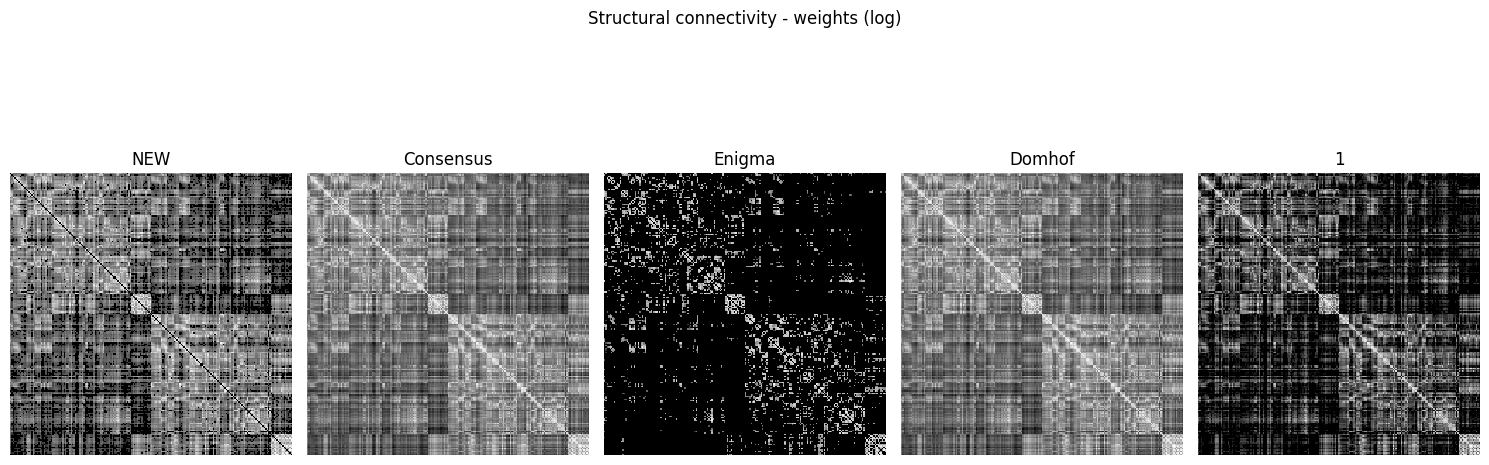

In [51]:
fig, axs = plt.subplots(1, 5, tight_layout=True,figsize=(15,6),sharey=True,sharex=True)
fig.suptitle("Structural connectivity - weights (log)")
plot_adjacency_matrix(SC_distance_consensus,axs[0],"NEW",norm=LogNorm(),mask=SC_distance_consensus==0)
plot_adjacency_matrix(SC_consensus,axs[1],"Consensus",norm=LogNorm(),mask=SC_consensus==0)
plot_adjacency_matrix(SC_W_ENIGMA,axs[2],"Enigma",mask=SC_W_ENIGMA==0)
plot_adjacency_matrix(SC_W_dom,axs[3],"Domhof",norm=LogNorm())
plot_adjacency_matrix(one_SC_example,axs[4],"1",norm=LogNorm())

In [52]:
df = pd.DataFrame({"PyTepFit":np.log(SC_W).flatten(),
                   "Domhof_basic":np.log(SC_W_dom).flatten(),
                   "Enigma": SC_W_ENIGMA.flatten(), 
                   "NEW": np.log(SC_distance_consensus).flatten(),
                   "consensus": np.log(SC_consensus).flatten(),
                   "1":np.log(one_SC_example).flatten()})
pg.pairwise_corr(df,method="spearman")

/tmp/ipykernel_8788/2713382127.py:4: RuntimeWarning: divide by zero encountered in log
  "NEW": np.log(SC_distance_consensus).flatten(),
/tmp/ipykernel_8788/2713382127.py:6: RuntimeWarning: divide by zero encountered in log
  "1":np.log(one_SC_example).flatten()})


,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,PyTepFit,Domhof_basic,spearman,two-sided,27722,0.835317,"[0.83, 0.84]",0.0,1.0
1,PyTepFit,Enigma,spearman,two-sided,4738,0.778632,"[0.77, 0.79]",0.0,1.0
2,PyTepFit,NEW,spearman,two-sided,27722,0.821473,"[0.82, 0.83]",0.0,1.0
3,PyTepFit,consensus,spearman,two-sided,27722,0.835318,"[0.83, 0.84]",0.0,1.0
4,PyTepFit,1,spearman,two-sided,27722,0.796853,"[0.79, 0.8]",0.0,1.0
5,Domhof_basic,Enigma,spearman,two-sided,4822,0.871037,"[0.86, 0.88]",0.0,1.0
6,Domhof_basic,NEW,spearman,two-sided,40000,0.949538,"[0.95, 0.95]",0.0,1.0
7,Domhof_basic,consensus,spearman,two-sided,40000,1.000000,"[1.0, 1.0]",0.0,1.0
8,Domhof_basic,1,spearman,two-sided,40000,0.915953,"[0.91, 0.92]",0.0,1.0
9,Enigma,NEW,spearman,two-sided,4822,0.840118,"[0.83, 0.85]",0.0,1.0


In [53]:
df

,PyTepFit,Domhof_basic,Enigma,NEW,consensus,1
0,NaN,8.097737,NaN,-inf,8.097737,7.100852
1,3.367296,6.721269,6.9394,6.721269,6.721269,5.669881
2,0.000000,3.092405,NaN,3.092405,3.092405,2.944439
3,0.000000,2.763485,NaN,2.763485,2.763485,1.791759
4,NaN,2.907720,NaN,2.907720,2.907720,2.197225
...,...,...,...,...,...,...
39995,4.317488,4.488355,NaN,4.488355,4.488355,3.044522
39996,8.853523,8.890310,9.4415,8.890310,8.890310,8.861208
39997,7.380879,7.880145,8.0526,7.880145,7.880145,7.392032
39998,5.525453,6.270204,NaN,6.270204,6.270204,5.805135


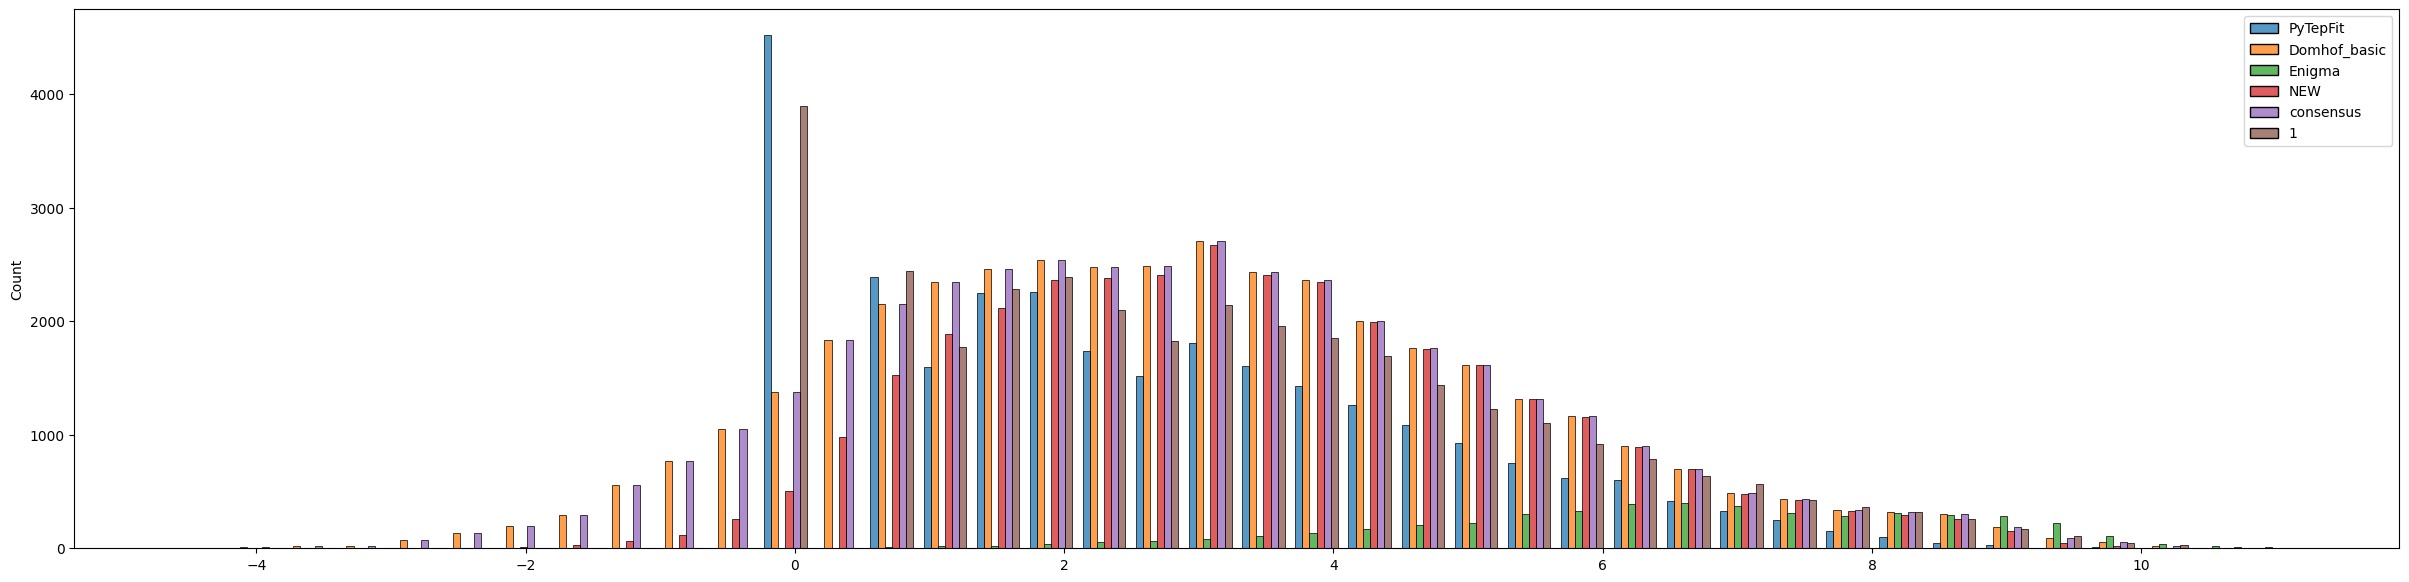

In [54]:
plt.figure(figsize=(30,7))
sns.histplot(df,bins = 40, multiple="dodge", shrink=.8,common_norm=False)
plt.show()

In [55]:
def get_lengths(matrix,ED):
    np.fill_diagonal(ED,np.nan)
    mask = matrix > 0
    return np.where(mask,ED,np.nan).flatten()

df_len = pd.DataFrame({"PyTepFit":get_lengths(SC_W,ED),"Domhof_basic":get_lengths(SC_W_dom,ED),"Enigma": get_lengths(SC_W_ENIGMA,ED),"consensus":get_lengths(SC_consensus,ED), "NEW": get_lengths(SC_distance_consensus,ED),"1":get_lengths(one_SC_example,ED)})
df_len

,PyTepFit,Domhof_basic,Enigma,consensus,NEW,1
0,NaN,NaN,NaN,NaN,NaN,NaN
1,31.857731,31.857731,31.857731,31.857731,31.857731,31.857731
2,80.579122,80.579122,NaN,80.579122,80.579122,80.579122
3,86.686843,86.686843,NaN,86.686843,86.686843,86.686843
4,NaN,81.857645,NaN,81.857645,81.857645,81.857645
...,...,...,...,...,...,...
39995,28.559253,28.559253,NaN,28.559253,28.559253,28.559253
39996,20.491755,20.491755,20.491755,20.491755,20.491755,20.491755
39997,33.067405,33.067405,33.067405,33.067405,33.067405,33.067405
39998,23.832636,23.832636,NaN,23.832636,23.832636,23.832636


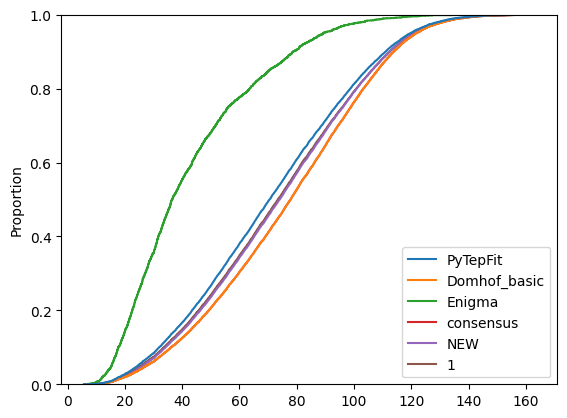

In [56]:
plt.figure(figsize=(5,5))
sns.ecdfplot(df_len)
plt.show()

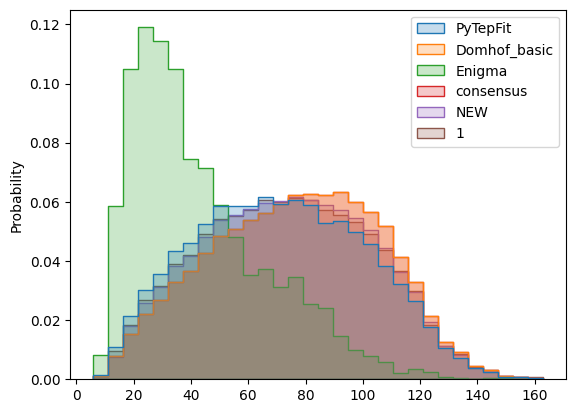

In [57]:
plt.figure()
sns.histplot(df_len,stat='probability',bins=30,element='step',common_norm=False)
plt.show()

In [58]:
df_len_domhof = df_len[["NEW","Domhof_basic","consensus","1"]]
df_len_domhof

,NEW,Domhof_basic,consensus,1
0,NaN,NaN,NaN,NaN
1,31.857731,31.857731,31.857731,31.857731
2,80.579122,80.579122,80.579122,80.579122
3,86.686843,86.686843,86.686843,86.686843
4,81.857645,81.857645,81.857645,81.857645
...,...,...,...,...
39995,28.559253,28.559253,28.559253,28.559253
39996,20.491755,20.491755,20.491755,20.491755
39997,33.067405,33.067405,33.067405,33.067405
39998,23.832636,23.832636,23.832636,23.832636


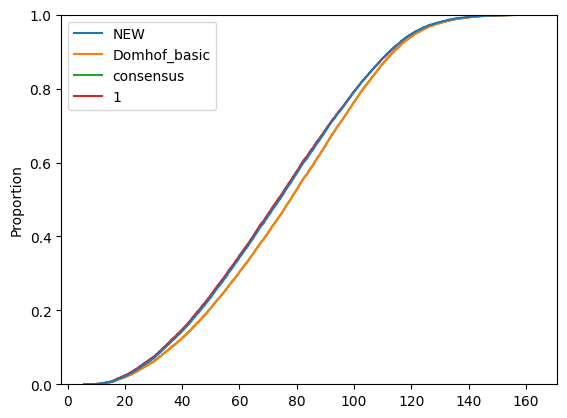

In [59]:
plt.figure()
sns.ecdfplot(df_len_domhof)
plt.show()

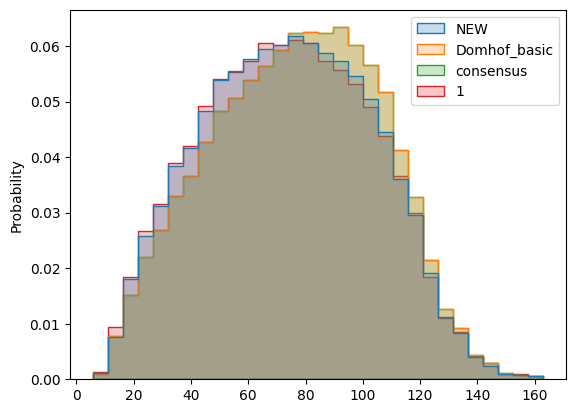

In [60]:
plt.figure()
sns.histplot(df_len_domhof,stat='probability',bins=30,element='step',common_norm=False)
plt.show()